In [1]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import cv2 as cv
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

import torch
import torch.nn as nn
from torch.optim import Adam, SGD
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision.transforms import ToTensor

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix

import pylab as pl
from IPython import display
from tqdm import tqdm

torch.manual_seed(33)

In [2]:
import pandas as pd

images_path = 'images/'
annotations_path = 'annotations/list.txt'

with open(annotations_path, 'r') as file:
    lines = [line.split() for line in file if not line.startswith('#')]

columns = ["Image", "CLASS-ID", "SPECIES", "BREED ID"]
df = pd.DataFrame(lines, columns=columns)

df["Image"] = images_path + df["Image"] + '.jpg'
df["CLASS-ID"] = df["CLASS-ID"].astype('int64')
df["SPECIES"] = df["SPECIES"].astype('int64')
df["BREED ID"] = df["BREED ID"].astype('int64')

numeric_columns = df.select_dtypes(include=['number']).columns
df[numeric_columns] = df[numeric_columns].apply(lambda x: x - 1)

print(df)

                                Image  CLASS-ID  SPECIES  BREED ID
0           images/Abyssinian_100.jpg         0        0         0
1           images/Abyssinian_101.jpg         0        0         0
2           images/Abyssinian_102.jpg         0        0         0
3           images/Abyssinian_103.jpg         0        0         0
4           images/Abyssinian_104.jpg         0        0         0
...                               ...       ...      ...       ...
7344  images/yorkshire_terrier_96.jpg        36        1        24
7345  images/yorkshire_terrier_97.jpg        36        1        24
7346  images/yorkshire_terrier_98.jpg        36        1        24
7347  images/yorkshire_terrier_99.jpg        36        1        24
7348   images/yorkshire_terrier_9.jpg        36        1        24

[7349 rows x 4 columns]


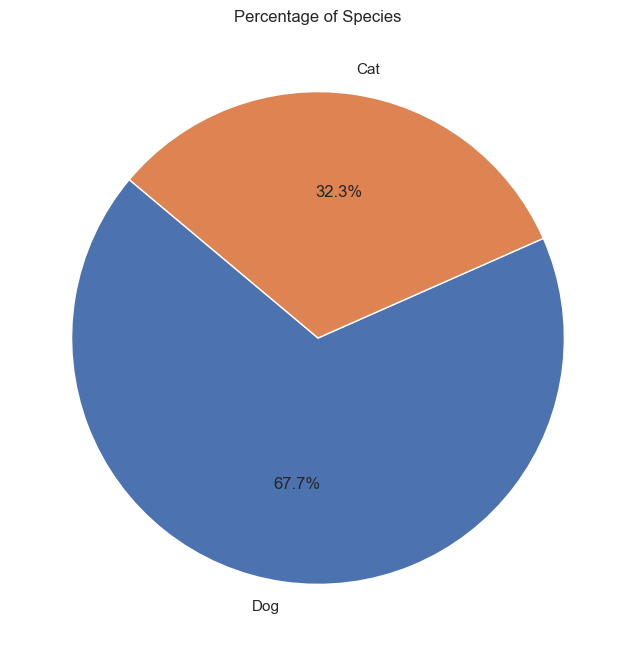

In [3]:
species_counts = df['SPECIES'].map({0: 'Cat', 1: 'Dog'}).value_counts()

plt.figure(figsize=(8, 8))
sns.set(style="whitegrid")
plt.title('Percentage of Species')
plt.pie(species_counts, labels=species_counts.index, autopct='%1.1f%%', startangle=140)
plt.show()

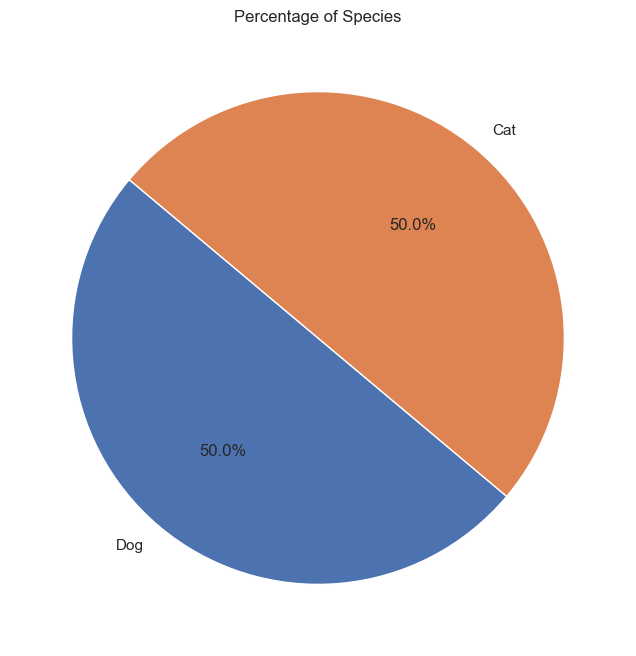

In [4]:
cats_df = df[df['SPECIES'] == 0]
dogs_df = df[df['SPECIES'] == 1]

min_samples = min(len(cats_df), len(dogs_df))
cats_sampled = cats_df.sample(n=min_samples, random_state=42)
dogs_sampled = dogs_df.sample(n=min_samples, random_state=42)

df_balanced = pd.concat([cats_sampled, dogs_sampled])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)


species_counts = df_balanced['SPECIES'].map({0: 'Cat', 1: 'Dog'}).value_counts()

plt.figure(figsize=(8, 8))
sns.set(style="whitegrid")
plt.title('Percentage of Species')
plt.pie(species_counts, labels=species_counts.index, autopct='%1.1f%%', startangle=140)
plt.show()

### OUR CNN

In [5]:
X = df_balanced[["Image"]]
y = df_balanced[["SPECIES"]]

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create new DataFrames for trAining and testing
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

class DogsCats(Dataset):
    def __init__(self, images, labels, transform):
        super().__init__()
        self.paths = images  # Use the provided images parameter
        self.labels = labels
        self.len = len(self.paths)
        self.transform = transform

    def __len__(self): 
        return self.len

    def __getitem__(self, index):
        path = self.paths.iloc[index]  # Assuming self.paths is a Pandas Series
        label = self.labels.iloc[index]

        # Read image using PIL
        image = Image.open(path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
            
        #label = torch.tensor(label)

        return image, label

transform = transforms.Compose([transforms.Resize((100, 100)),
                                transforms.ToTensor()])

train_ds = DogsCats(train_df['Image'], train_df['SPECIES'], transform)
train_dl = DataLoader(train_ds, batch_size=64)

test_ds = DogsCats(test_df['Image'], test_df['SPECIES'], transform)
test_dl = DataLoader(test_ds, batch_size=64)

iterador =  iter(train_dl) 

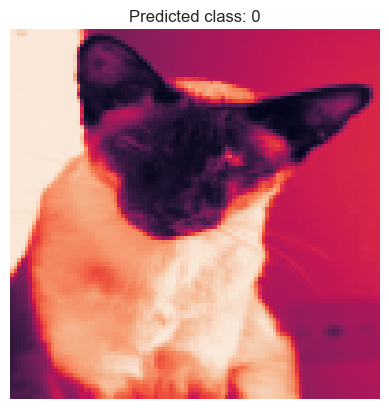

Etiqueta: 0
Saber l'estructura del batch us ajudarà: 
Feature batch shape: torch.Size([64, 3, 100, 100])
Labels batch shape: torch.Size([64])


In [6]:
features, labels = next(iterador)

plt.imshow(features[0][0])
plt.axis("off")
plt.title(f"Predicted class: {labels[0].item()}")
plt.show()

print(f"Etiqueta: {labels[0].item()}")
print("Saber l'estructura del batch us ajudarà: ")
print(f"Feature batch shape: {features.size()}")
print(f"Labels batch shape: {labels.size()}")

In [7]:
from collections import OrderedDict

class SuperCNNSuperGuay(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(SuperCNNSuperGuay, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels, 5, kernel_size=3, stride=1, padding=1)
        self.conv_2 = nn.Conv2d(5, 10, kernel_size=3, stride=1, padding=1)
        self.conv_3 = nn.Conv2d(10, 16, kernel_size=3, stride=1, padding=1)
        self.conv_4 = nn.Conv2d(16, 24, kernel_size=3, stride=1, padding=1)
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear_1 = nn.Linear(24*6*6, 200)
        self.linear_2 = nn.Linear(200, 10)
        self.linear_3 = nn.Linear(10, 2)
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.conv_1(x)
        x = self.max_pool2d(x)
        x = self.relu(x)
        
        x = self.conv_2(x)
        x = self.max_pool2d(x)
        x = self.relu(x)
        
        x = self.conv_3(x)
        x = self.max_pool2d(x)
        x = self.relu(x)
        
        x = self.conv_4(x)
        x = self.max_pool2d(x)
        x = self.dropout(x)
        x = self.relu(x)
        
        
        x = torch.flatten(x, 1)
        x = self.linear_1(x)
        x = self.dropout(x)
        x = self.relu(x)
        
        x = self.linear_2(x)
        x = self.relu(x)

        x = self.linear_3(x)

        return F.log_softmax(x, dim=1)
    
    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [

                ]
            )
        )
    
class SuperFCNSuperGuay(nn.Module):
    def __init__(self, in_channels=3, out_channels=2, init_features=32):
        super(SuperFCNSuperGuay, self).__init__()
        
        self.conv_1 = nn.Conv2d(in_channels, 8, kernel_size=3, stride=1, padding=1)
        self.conv_2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.conv_3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv_4 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv_5 = nn.Conv2d(64, out_channels, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        
    def forward(self, x):
        x = self.relu(self.conv_1(x))
        x = self.max_pool(x)
        
        x = self.relu(self.conv_2(x))
        
        x = self.relu(self.conv_3(x))
        x = self.max_pool(x)
        
        x = self.relu(self.conv_4(x))
        
        x = self.relu(self.conv_5(x))
        x = self.dropout(x)
        
        x = self.avg_pool(x)
        
        return x.squeeze()

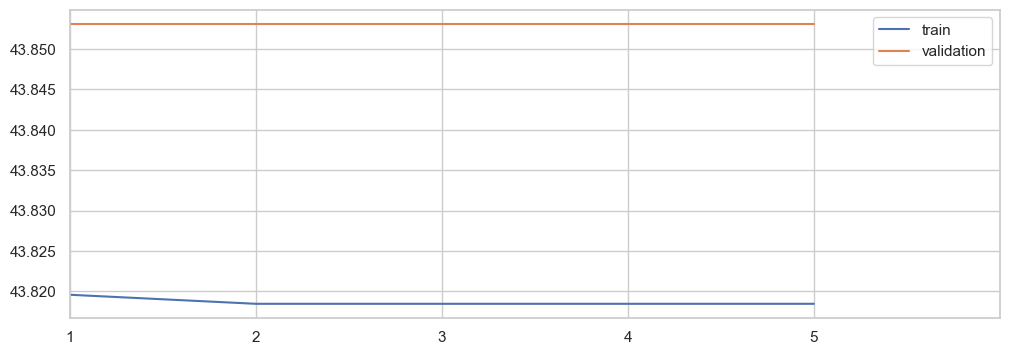

Epoch:5 Training Loss:43.81847318013509 Validation Loss:43.85312957763672: 100%|█████████| 5/5 [01:13<00:00, 14.72s/it]


In [10]:
use_cuda = True
torch.manual_seed(33)

if use_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model = SuperFCNSuperGuay().to(device)

epochs = 5
lr = 1e-3

optimizer = Adam(model.parameters(), lr=lr)

t_loss = np.zeros((epochs))
v_loss = np.zeros((epochs))

pbar = tqdm(range(1, epochs+1)) # tdqm permet tenir text dinàmic
for epoch in pbar:
    
    train_loss = 0 
    val_loss = 0  
    
    model.train()                                                  
    for batch_num, (input_img, target) in enumerate(train_dl, 1):   
        input_img= input_img.to(device)
        optimizer.zero_grad()     
        
        target = target.to(device)
        output = model(input_img)

        loss = F.cross_entropy(output, target, reduction='sum') 
        loss.backward()                                            
        
        optimizer.step()                                               
        
        train_loss += loss.item()    
                                                       
    model.eval()   
    with torch.no_grad():                                          
        for input_img, target in test_dl: 
            input_img = input_img.to(device)
            target = target.to(device)
            
            output = model(input_img)                                   
            loss = F.cross_entropy(output, target, reduction='sum') 
            val_loss += loss.item()  
    
    # RESULTATS
    train_loss /= len(train_dl)
    t_loss[epoch-1] = train_loss
    
    val_loss /= len(test_dl)   
    v_loss[epoch-1] = val_loss
    
    # VISUALITZACIO DINAMICA
    plt.figure(figsize=(12, 4))
    pl.plot(t_loss[:epoch], label="train")
    pl.plot(v_loss[:epoch], label="validation")
    pl.legend()
    pl.xlim(0, epochs)
    pl.xticks(range(0,epochs,1),range(1,epochs+1,1))
    
    display.clear_output(wait=True)
    display.display(pl.gcf())
    plt.close()

    pbar.set_description(f"Epoch:{epoch} Training Loss:{train_loss} Validation Loss:{val_loss}")

Checking accuracy on Test Set


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.70it/s]


Accuracy: 50.05%


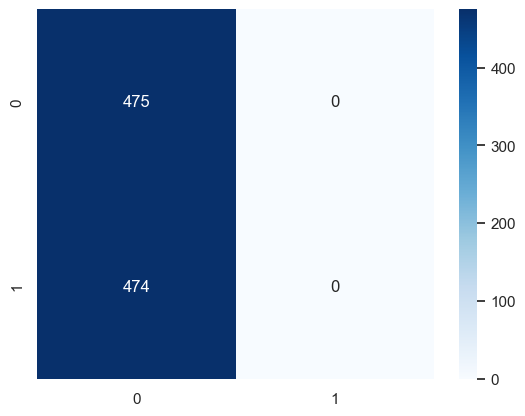

In [11]:
from sklearn.metrics import confusion_matrix

def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    all_true_labels = []
    all_predicted_labels = []

    with torch.no_grad():
        for x, y in tqdm(loader):
            x = x.to(device=device, dtype=torch.float)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum().item()
            num_samples += predictions.size(0)

            # Collect true and predicted labels for the confusion matrix
            all_true_labels.extend(y.cpu().numpy())
            all_predicted_labels.extend(predictions.cpu().numpy())

        accuracy = num_correct / num_samples
        print(f"Accuracy: {accuracy * 100:.2f}%")

    model.train()
    
    class_names = list(set(all_true_labels + all_predicted_labels))

    sns.heatmap(confusion_matrix(all_true_labels, all_predicted_labels), annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    
print("Checking accuracy on Test Set")
check_accuracy(test_dl, model)

In [13]:
import torch
import torch.nn as nn
import torchvision

class InceptionModel(nn.Module):
    def __init__(self):
        super(InceptionModel, self).__init__()
        # Load pre-trained GoogLeNet
        self.base_model = torchvision.models.googlenet(pretrained=True)
        
        # Modify the fully connected layers
        self.base_model.fc = nn.Sequential(
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=2, bias=True)
        )
    
    def forward(self, x):
        return self.base_model(x)

# Create an instance of the InceptionModel
model = InceptionModel()

# Move the model to the desired device (e.g., GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print('Inception loaded')

Inception loaded


In [14]:
learning_rate = 1e-3
num_epochs = 10

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate)

# Train Network
for epoch in range(num_epochs):
    losses = []

    for batch_idx, (data, targets) in tqdm(enumerate(train_dl)):
        # Get data to cuda if possible
        data = data.to(device=device,dtype=torch.float)
        targets = targets.to(device=device)

        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        losses.append(loss.item())

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

    print(f"Cost at epoch {epoch} is {sum(losses)/len(losses)}")

60it [00:14,  4.28it/s]


Cost at epoch 0 is 0.32538843688865504


60it [00:13,  4.32it/s]


Cost at epoch 1 is 0.12760044910634558


60it [00:13,  4.38it/s]


Cost at epoch 2 is 0.08515854789099346


60it [00:13,  4.47it/s]


Cost at epoch 3 is 0.05944620062752316


60it [00:13,  4.36it/s]


Cost at epoch 4 is 0.059155855467543005


60it [00:13,  4.41it/s]


Cost at epoch 5 is 0.04729215427263019


60it [00:13,  4.37it/s]


Cost at epoch 6 is 0.03176330424030312


60it [00:13,  4.39it/s]


Cost at epoch 7 is 0.03989497195774069


60it [00:13,  4.42it/s]


Cost at epoch 8 is 0.039530863747252926


60it [00:13,  4.34it/s]

Cost at epoch 9 is 0.03777920553887573


Checking accuracy on Test Set


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.66it/s]


Accuracy: 86.20%


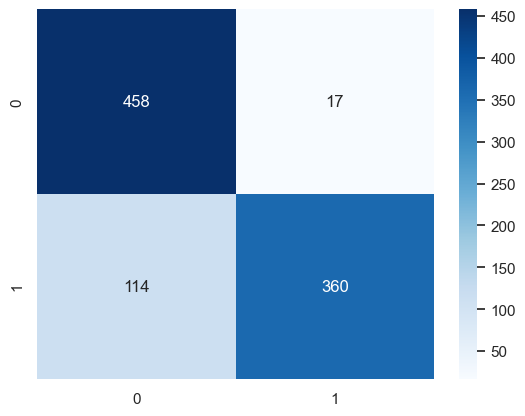

In [16]:
print("Checking accuracy on Test Set")
check_accuracy(test_dl, model)

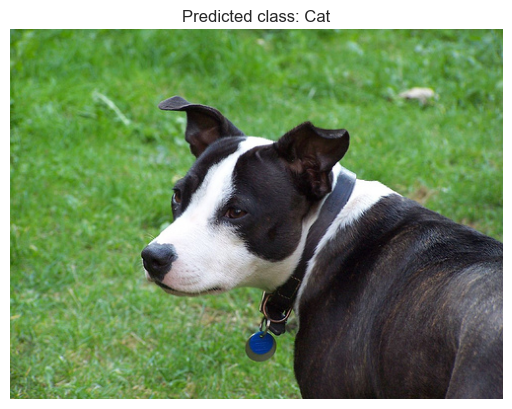

tensor([-0.1027, -0.1883], device='cuda:0')


In [30]:
transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

class_mapping = {0: 'Cat', 1: 'Dog'}

import random

# Get the maximum index in the DataFrame
max_index = len(df) - 1

# Generate a random index between 1 and max_index
i = random.randint(1, max_index)

# Load an image from a file path
image_path = df.iloc[i]['Image']
image = Image.open(image_path).convert("RGB")

# Apply the transform to preprocess the image
input_image = transform(image).unsqueeze(0)  # Add a batch dimension

# Move the input image to the appropriate device
input_image = input_image.to(device)

# Ensure the model is in evaluation mode
model.eval()

# Forward pass the preprocessed image through the model
with torch.no_grad():
    output = model(input_image)
    # Interpret the model's output
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    predicted_class_index = torch.argmax(probabilities).item()
    predicted_class_name = class_mapping.get(predicted_class_index, "Unknown")

    # Display the original image and show the predicted class
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Predicted class: {predicted_class_name}")
    plt.show()
    print(output[0])


### Proves amb fotos a local

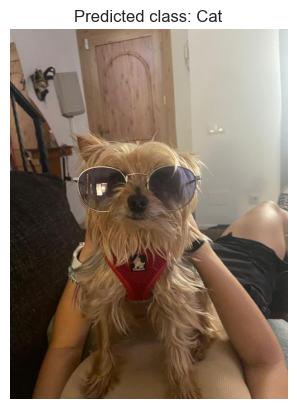

tensor([ 0.3734, -0.9871], device='cuda:0')


In [33]:
# Load an image from a file path
image_path = 'C:/Users/marti/Downloads/ema2.jpeg'
image = Image.open(image_path).convert("RGB")

# Apply the transform to preprocess the image
input_image = transform(image).unsqueeze(0)  # Add a batch dimension

# Move the input image to the appropriate device
input_image = input_image.to(device)

# Ensure the model is in evaluation mode
model.eval()

# Forward pass the preprocessed image through the model
with torch.no_grad():
    output = model(input_image)
    # Interpret the model's output
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    predicted_class_index = torch.argmax(probabilities).item()
    predicted_class_name = class_mapping.get(predicted_class_index, "Unknown")

    # Display the original image and show the predicted class
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Predicted class: {predicted_class_name}")
    plt.show()
    print(output[0])


# Apartat 2

In [7]:
X = df_balanced[["Image"]]
y = df_balanced[["CLASS-ID"]]

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create new DataFrames for trAining and testing
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

class DogsCats(Dataset):
    def __init__(self, images, labels, transform):
        super().__init__()
        self.paths = images  # Use the provided images parameter
        self.labels = labels
        self.len = len(self.paths)
        self.transform = transform

    def __len__(self): 
        return self.len

    def __getitem__(self, index):
        path = self.paths.iloc[index]  # Assuming self.paths is a Pandas Series
        label = self.labels.iloc[index]

        # Read image using PIL
        image = Image.open(path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
            
        #label = torch.tensor(label)

        return image, label

transform = transforms.Compose([transforms.Resize((100, 100)),
                                transforms.ToTensor()])

train_ds = DogsCats(train_df['Image'], train_df['CLASS-ID'], transform)
train_dl = DataLoader(train_ds, batch_size=64)

test_ds = DogsCats(test_df['Image'], test_df['CLASS-ID'], transform)
test_dl = DataLoader(test_ds, batch_size=64)

iterador =  iter(train_dl) 

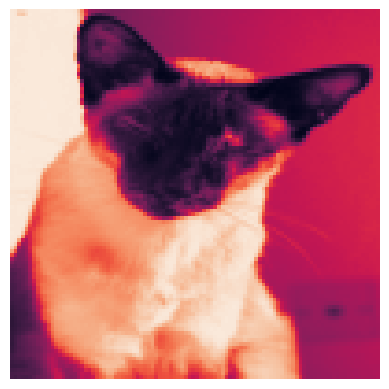

Etiqueta: 32
Saber l'estructura del batch us ajudarà: 
Feature batch shape: torch.Size([64, 3, 100, 100])
Labels batch shape: torch.Size([64])


In [8]:
features, labels = next(iterador)

plt.imshow(features[0][0])
plt.axis("off")
plt.show()

print(f"Etiqueta: {labels[0].item()}")
print("Saber l'estructura del batch us ajudarà: ")
print(f"Feature batch shape: {features.size()}")
print(f"Labels batch shape: {labels.size()}")

In [10]:
import torch
import torch.nn as nn
import torchvision

class InceptionModelBreed(nn.Module):
    def __init__(self):
        super(InceptionModelBreed, self).__init__()
        # Load pre-trained GoogLeNet
        self.base_model = torchvision.models.googlenet(pretrained=True)
        
        # Modify the fully connected layers
        self.base_model.fc = nn.Sequential(
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=37, bias=True)
        )

    
    def forward(self, x):
        return self.base_model(x)

# Create an instance of the InceptionModel
model = InceptionModelBreed()

# Move the model to the desired device (e.g., GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print('Inception loaded')

Inception loaded


In [17]:
learning_rate = 1e-5
num_epochs = 35

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate)

# Train Network
for epoch in range(num_epochs):
    losses = []

    for batch_idx, (data, targets) in tqdm(enumerate(train_dl)):
        # Get data to cuda if possible
        data = data.to(device=device,dtype=torch.float)
        targets = targets.to(device=device)

        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        losses.append(loss.item())

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

    print(f"Cost at epoch {epoch} is {sum(losses)/len(losses)}")

60it [00:13,  4.61it/s]


Cost at epoch 0 is 1.198687163988749


60it [00:12,  4.66it/s]


Cost at epoch 1 is 1.0736643383900324


60it [00:12,  4.69it/s]


Cost at epoch 2 is 1.0014875600735347


60it [00:12,  4.68it/s]


Cost at epoch 3 is 0.944825894633929


60it [00:12,  4.65it/s]


Cost at epoch 4 is 0.8994126160939534


60it [00:13,  4.61it/s]


Cost at epoch 5 is 0.8611216257015865


60it [00:13,  4.60it/s]


Cost at epoch 6 is 0.8281854510307312


60it [00:12,  4.62it/s]


Cost at epoch 7 is 0.7974683811267217


60it [00:13,  4.61it/s]


Cost at epoch 8 is 0.7667838831742605


60it [00:12,  4.64it/s]


Cost at epoch 9 is 0.7419677515824635


60it [00:12,  4.64it/s]


Cost at epoch 10 is 0.7183968464533488


60it [00:12,  4.64it/s]


Cost at epoch 11 is 0.6940482546885808


60it [00:12,  4.66it/s]


Cost at epoch 12 is 0.6718777830402056


60it [00:12,  4.68it/s]


Cost at epoch 13 is 0.649756578107675


60it [00:12,  4.63it/s]


Cost at epoch 14 is 0.630418486893177


60it [00:12,  4.66it/s]


Cost at epoch 15 is 0.6103646914164226


60it [00:12,  4.65it/s]


Cost at epoch 16 is 0.5917737369736036


60it [00:12,  4.68it/s]


Cost at epoch 17 is 0.5724282587567965


60it [00:12,  4.64it/s]


Cost at epoch 18 is 0.5556418433785438


60it [00:12,  4.65it/s]


Cost at epoch 19 is 0.5392025316754977


60it [00:12,  4.67it/s]


Cost at epoch 20 is 0.5174072841803233


60it [00:12,  4.66it/s]


Cost at epoch 21 is 0.5054408088326454


60it [00:12,  4.67it/s]


Cost at epoch 22 is 0.4908000111579895


60it [00:12,  4.69it/s]


Cost at epoch 23 is 0.47267691741387047


60it [00:12,  4.67it/s]


Cost at epoch 24 is 0.45804252674182255


60it [00:12,  4.66it/s]


Cost at epoch 25 is 0.4431659445166588


60it [00:12,  4.66it/s]


Cost at epoch 26 is 0.42882245779037476


60it [00:12,  4.66it/s]


Cost at epoch 27 is 0.4125350184738636


60it [00:12,  4.69it/s]


Cost at epoch 28 is 0.40124271959066393


60it [00:12,  4.71it/s]


Cost at epoch 29 is 0.3849418977896372


60it [00:12,  4.68it/s]


Cost at epoch 30 is 0.3740626206000646


60it [00:12,  4.70it/s]


Cost at epoch 31 is 0.35866955692569413


60it [00:12,  4.66it/s]


Cost at epoch 32 is 0.3474464510877927


60it [00:12,  4.64it/s]


Cost at epoch 33 is 0.3366561601559321


60it [00:13,  4.52it/s]

Cost at epoch 34 is 0.3232270523905754


Checking accuracy on Test Set


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.05it/s]


Accuracy: 55.74%


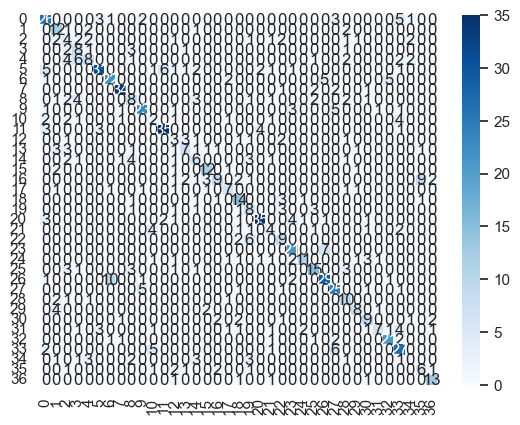

In [18]:
print("Checking accuracy on Test Set")
check_accuracy(test_dl, model)